<a href="https://colab.research.google.com/github/s-gregorini003/ase-sequencer-project/blob/master/tflite_multiclass_speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x           # select the latest TF 2 version (2.1.1)
from os import listdir            # os is used to deal with the files
from os.path import isdir, join
import tarfile
import tensorflow as tf
# import tensorflow_datasets as tfds
import librosa                    # loading and resampling audio files
import random                     # shuffling data
import numpy as np                # matrices operations
import matplotlib.pyplot as plt   # graphics

# **1 Feature Extraction**

## **1.1 Raw Dataset Download**

In [3]:
# Code cell 1.1.1
!pip install python_speech_features
import python_speech_features     # features extraction

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=29fddf3951143b3d3a89f7d83c53b9eb0f9b19eb72491a51ef889db2ab85f56f
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [4]:
# Code cell 1.1.2
!wget --no-check-certificate \
    http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz \
    -O /tmp/speech_commands_v0.02.tar.gz

local_tar = '/tmp/speech_commands_v0.02.tar.gz'
tar_ref = tarfile.open(local_tar, 'r')
tar_ref.extractall('/tmp/speech_commands')
tar_ref.close()

--2020-06-12 11:39:29--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.125.128, 2404:6800:4008:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.125.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘/tmp/speech_commands_v0.02.tar.gz’

/tmp/speech_command 100%[===================>]   2.26G  71.3MB/s    in 32s     

2020-06-12 11:40:02 (72.5 MB/s) - ‘/tmp/speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



In [5]:
# Code cell 1.1.3
# Set the path to the collected dataset
dataset_folder_path = '/tmp/speech_commands'  # Downloaded dataset path
for name in listdir(dataset_folder_path):
  if isdir(join(dataset_folder_path, name)):
    print(name)

seven
six
nine
follow
bed
_background_noise_
yes
dog
bird
zero
tree
happy
sheila
house
one
four
off
eight
backward
go
stop
cat
left
up
forward
three
visual
two
on
down
wow
right
no
five
marvin
learn


In [6]:
# Code cell 1.1.4
# Array of subfolders contained in the dataset
dataset_subfolders = [name for name in listdir(dataset_folder_path) if isdir(join(dataset_folder_path, name))]
print(dataset_subfolders)

# Files count in each subfolder
num_samples = 0
for subfolder in dataset_subfolders:
  print(subfolder, len(listdir(join(dataset_folder_path, subfolder))))
  num_samples += len(listdir(join(dataset_folder_path, subfolder)))
print('Total files:', num_samples)

['seven', 'six', 'nine', 'follow', 'bed', '_background_noise_', 'yes', 'dog', 'bird', 'zero', 'tree', 'happy', 'sheila', 'house', 'one', 'four', 'off', 'eight', 'backward', 'go', 'stop', 'cat', 'left', 'up', 'forward', 'three', 'visual', 'two', 'on', 'down', 'wow', 'right', 'no', 'five', 'marvin', 'learn']
seven 3998
six 3860
nine 3934
follow 1579
bed 2014
_background_noise_ 7
yes 4044
dog 2128
bird 2064
zero 4052
tree 1759
happy 2054
sheila 2022
house 2113
one 3890
four 3728
off 3745
eight 3787
backward 1664
go 3880
stop 3872
cat 2031
left 3801
up 3723
forward 1557
three 3727
visual 1592
two 3880
on 3845
down 3917
wow 2123
right 3778
no 3941
five 4052
marvin 2100
learn 1575
Total files: 105836


## **1.2 Extract Features from Raw Data**

In [0]:
# Code cell 1.2.1
# Preliminary parameters
target_list = dataset_subfolders
feature_sets_file = 'dataset_subfolders_mfcc_sets.npz'
samples_percentage = 1          # Percentage of the samples to be randomly picked from the dataset
val_ratio = 0.2                   # Ratio of samples used for validation (from the randomly picked percentage)
test_ratio = 0.2                  # Ratio of samples used for testing (from the randomly picked percentage)
sample_rate = 8000                # Sample rate of the audio samples
num_mfcc = 16                     # Number of mfccs to be generated
len_mfcc = 50                     # Length of the mffc matrix for a single audio utterance

neg_labels_percent = 0.3          # Percentage of 'negative' samples to be kept 
wake_words = ['on', 'off', 'up', 'down', 'visual', 'bed']     # Wake words to be used

In [0]:
# Code cell 1.2.2
# Create a list of filenames with their complete path and label vectors
filenames = []
y = []
wake_word_index_vec = []
not_wake_word_index_vec = []

for index, target in enumerate(target_list):
  print(join(dataset_folder_path, target))
  filenames.append(listdir(join(dataset_folder_path, target)))
  y.append(np.ones(len(filenames[index])) * index)

  if target not in wake_words:
    filenames[index] = filenames[index][:int(len(listdir(join(dataset_folder_path, target)))*neg_labels_percent)]
    y[index] = y[index][:int(len(listdir(join(dataset_folder_path, target)))*neg_labels_percent)]
    not_wake_word_index_vec.append(index)
  else:
    wake_word_index_vec.append(index)

# Flatten filenames and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

print('number of features:', len(filenames))
print('number of labels:', len(y))
print('wake words:', wake_word_index_vec)
print('not wake words:', not_wake_word_index_vec)

/tmp/speech_commands/tree
/tmp/speech_commands/two
/tmp/speech_commands/stop
/tmp/speech_commands/bed
/tmp/speech_commands/house
/tmp/speech_commands/five
/tmp/speech_commands/forward
/tmp/speech_commands/up
/tmp/speech_commands/bird
/tmp/speech_commands/off
/tmp/speech_commands/visual
/tmp/speech_commands/down
/tmp/speech_commands/marvin
/tmp/speech_commands/left
/tmp/speech_commands/yes
/tmp/speech_commands/sheila
/tmp/speech_commands/backward
/tmp/speech_commands/go
/tmp/speech_commands/_background_noise_
/tmp/speech_commands/three
/tmp/speech_commands/learn
/tmp/speech_commands/cat
/tmp/speech_commands/six
/tmp/speech_commands/right
/tmp/speech_commands/dog
/tmp/speech_commands/eight
/tmp/speech_commands/happy
/tmp/speech_commands/zero
/tmp/speech_commands/four
/tmp/speech_commands/seven
/tmp/speech_commands/wow
/tmp/speech_commands/follow
/tmp/speech_commands/on
/tmp/speech_commands/one
/tmp/speech_commands/no
/tmp/speech_commands/nine
number of features: 44926
number of labels: 4

In [0]:
# Code cell 1.2.3
# Associate filenames with label and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

# Keep the percentage of samples previously defined
print('Number of total samples in the dataset:', len(filenames))
filenames = filenames[:int(len(filenames) * samples_percentage)]
print('Number of samples picked:', len(filenames))

Number of total samples in the dataset: 44926
Number of samples picked: 44926


In [0]:
# Code cell 1.2.4
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

# Split the dataset into train, validation and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

# Split y vector into train, validation and test labels
y_raw_val = y[:val_set_size]
y_raw_test = y[val_set_size:(val_set_size + test_set_size)]
y_raw_train = y[(val_set_size + test_set_size):]

In [0]:
# Code cell 1.2.5
# Function to create MFCC from path
def calc_mfcc_delta(path):
  
  # Load wavefile
  signal, fs = librosa.load(path, sr=sample_rate)

  # Generate MFCC from sound clip
  mfccs = python_speech_features.base.mfcc(signal,
                                          samplerate=fs,
                                          winlen=0.02,       # default 0.025
                                          winstep=0.02,      # default is 0.01
                                          numcep=num_mfcc,
                                          nfilt=26,
                                          nfft=512,         
                                          preemph=0.0,
                                          ceplifter=0,
                                          appendEnergy=True,
                                          winfunc=np.hanning)
  
  delta = python_speech_features.base.delta(mfccs, 2)

  mfccs_delta = np.append(mfccs, delta, axis=1)

  return mfccs_delta.transpose()

In [0]:
# Code cell 1.2.6
#=======  TEST  =======#
# Compute MFCC of 500 WAV files
prob_cnt = 0
x_tmp = []
y_tmp = []
for index, filename in enumerate(filenames_train):

  # Stop after 500
  if index >= 500:
    break

  # Create path from given filename and target item
  path = join(dataset_folder_path, target_list[int(y_raw_train[index])],
              filename)

  # Generate MFCCs
  mfccs = calc_mfcc_delta(path)

  if mfccs.shape[1] == len_mfcc:    # Check for corrupted files
    x_tmp.append(mfccs)
    y_tmp.append(y_raw_train[index])
  else:
    print('Dropped:', index, mfccs.shape)
    prob_cnt += 1

print('% of problematic samples:', prob_cnt / 500)    

Dropped: 7 (32, 47)
Dropped: 10 (32, 45)
Dropped: 11 (32, 24)
Dropped: 30 (32, 38)
Dropped: 53 (32, 43)
Dropped: 58 (32, 38)
Dropped: 60 (32, 49)
Dropped: 66 (32, 39)
Dropped: 86 (32, 45)
Dropped: 88 (32, 41)
Dropped: 115 (32, 47)
Dropped: 125 (32, 42)
Dropped: 145 (32, 47)
Dropped: 146 (32, 45)
Dropped: 178 (32, 42)
Dropped: 191 (32, 33)
Dropped: 200 (32, 38)
Dropped: 203 (32, 47)
Dropped: 224 (32, 39)
Dropped: 232 (32, 49)
Dropped: 235 (32, 47)
Dropped: 237 (32, 32)
Dropped: 245 (32, 35)
Dropped: 247 (32, 45)
Dropped: 255 (32, 31)
Dropped: 258 (32, 47)
Dropped: 268 (32, 42)
Dropped: 282 (32, 42)
Dropped: 303 (32, 28)
Dropped: 310 (32, 38)
Dropped: 316 (32, 42)
Dropped: 317 (32, 41)
Dropped: 326 (32, 38)
Dropped: 349 (32, 47)
Dropped: 352 (32, 47)
Dropped: 388 (32, 45)
Dropped: 397 (32, 35)
Dropped: 400 (32, 41)
Dropped: 432 (32, 38)
% of problematic samples: 0.078


MFCCs: [[-18.46490502 -15.85792026 -16.57249757 ... -15.69558191 -16.48695182
  -16.23446165]
 [ -5.61426966  -6.15481494  -6.48479608 ...   6.06180402   4.56131343
    4.27719733]
 [  0.73637131  -3.95482393  -5.57601945 ...   1.06371824   5.49354563
    1.83263584]
 ...
 [ -0.58990919  -0.40122829  -0.02761752 ...   0.20306621   0.09785643
    0.08120493]
 [  0.43120718   0.37766462   0.08243605 ...  -0.38817236  -0.0262417
    0.52577594]
 [  0.37670806   0.20423698  -0.22494616 ...   0.26974207   0.10804344
   -0.4079928 ]]
up


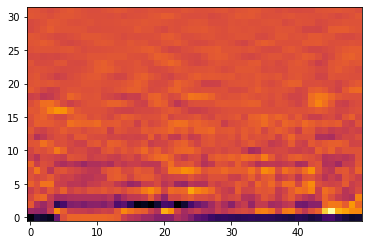

In [0]:
# Code cell 1.2.7
#=======  TEST  =======#
# Analyse corrupted samples
from IPython.display import Audio       # Tool for playing audio files

file_idx = 268 # ADD INDEX OF THE CORRUPTED SAMPLE

# Create path from given filename and target item
path = join(dataset_folder_path, target_list[int(y_raw_train[file_idx])],
            filenames_train[file_idx])

# Generate MFCCs
mfccs = calc_mfcc_delta(path)
print('MFCCs:', mfccs)

# Plot MFCCs
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# Play sample
print(target_list[int(y_raw_train[file_idx])])
Audio(filename=path)

In [0]:
# Code cell 1.2.8
# Function to extract features and drop corrupted samples
def extract_features(in_files, in_y):
  prob_cnt = 0
  out_x = []
  out_y = []

  for index, filename in enumerate(in_files):

    # Create path from given filename and target item
    path = join(dataset_folder_path, target_list[int(in_y[index])], 
                filename)
    
    # Check that the targeted file is WAV
    if not path.endswith('.wav'):
      continue

    # Generate MFCCs
    mfccs = calc_mfcc_delta(path)

    # Keep MFCCs with given length
    if mfccs.shape[1] == len_mfcc:
      out_x.append(mfccs)
      out_y.append(in_y[index])
    else:
      print('Dropped:', index, mfccs.shape)
      prob_cnt += 1

  return out_x, out_y, prob_cnt

In [0]:
# Code cell 1.2.9
# Create train, validation, test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_raw_train)
print('Removed percentage:', prob / len(y_raw_train))
x_val, y_val, prob = extract_features(filenames_val, 
                                          y_raw_val)
print('Removed percentage:', prob / len(y_raw_val))
x_test, y_test, prob = extract_features(filenames_test, 
                                          y_raw_test)
print('Removed percentage:', prob / len(y_raw_test))

Dropped: 3 (32, 43)
Dropped: 25 (32, 40)
Dropped: 31 (32, 43)
Dropped: 40 (32, 32)
Dropped: 43 (32, 45)
Dropped: 47 (32, 43)
Dropped: 51 (32, 45)
Dropped: 58 (32, 47)
Dropped: 64 (32, 35)
Dropped: 114 (32, 41)
Dropped: 124 (32, 41)
Dropped: 147 (32, 49)
Dropped: 148 (32, 45)
Dropped: 163 (32, 38)
Dropped: 168 (32, 38)
Dropped: 172 (32, 35)
Dropped: 187 (32, 41)
Dropped: 223 (32, 32)
Dropped: 228 (32, 45)
Dropped: 235 (32, 35)
Dropped: 237 (32, 49)
Dropped: 238 (32, 45)
Dropped: 247 (32, 47)
Dropped: 250 (32, 38)
Dropped: 258 (32, 47)
Dropped: 259 (32, 49)
Dropped: 263 (32, 41)
Dropped: 292 (32, 39)
Dropped: 328 (32, 38)
Dropped: 335 (32, 45)
Dropped: 341 (32, 35)
Dropped: 346 (32, 35)
Dropped: 348 (32, 30)
Dropped: 358 (32, 32)
Dropped: 392 (32, 47)
Dropped: 406 (32, 47)
Dropped: 407 (32, 47)
Dropped: 411 (32, 42)
Dropped: 414 (32, 37)
Dropped: 415 (32, 38)
Dropped: 423 (32, 49)
Dropped: 436 (32, 47)
Dropped: 438 (32, 35)
Dropped: 440 (32, 45)
Dropped: 445 (32, 45)
Dropped: 449 (32, 30

In [0]:
# Code cell 1.2.10
# Rename the labels acccording to the number of classes (number of wake words + "not wake word" label)

for i, t in enumerate(y_train):
  if t in not_wake_word_index_vec:
    y_train[i] = len(wake_words)
  else:
    y_train[i] = wake_word_index_vec.index(t)

for i, t in enumerate(y_val):
  if t in not_wake_word_index_vec:
    y_val[i] = len(wake_words)
  else:
    y_val[i] = wake_word_index_vec.index(t)

for i, t in enumerate(y_test):
  if t in not_wake_word_index_vec:
    y_test[i] = len(wake_words)
  else:
    y_test[i] = wake_word_index_vec.index(t)

wake_word_index_vec.append(len(wake_words))
print(wake_word_index_vec)

[3, 7, 9, 10, 11, 32, 6]


In [0]:
print(y_test[600:1070])

[2, 0, 3, 6, 2, 6, 6, 6, 5, 5, 6, 6, 4, 6, 6, 1, 6, 6, 6, 6, 6, 0, 6, 2, 6, 1, 6, 6, 5, 5, 0, 6, 1, 2, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 5, 1, 6, 6, 6, 6, 6, 6, 6, 5, 2, 4, 3, 0, 6, 6, 5, 6, 6, 5, 6, 6, 6, 2, 6, 6, 6, 6, 6, 5, 6, 5, 0, 6, 6, 6, 4, 4, 6, 6, 5, 0, 5, 6, 6, 4, 4, 6, 4, 6, 6, 2, 6, 0, 1, 1, 1, 6, 5, 6, 6, 6, 6, 1, 6, 1, 6, 1, 4, 6, 6, 4, 0, 2, 6, 2, 6, 4, 6, 5, 6, 1, 6, 1, 6, 6, 6, 6, 2, 6, 5, 3, 6, 6, 6, 2, 6, 3, 6, 2, 6, 6, 3, 6, 6, 6, 0, 5, 6, 6, 6, 3, 5, 6, 2, 4, 6, 2, 5, 6, 2, 6, 5, 6, 6, 0, 6, 2, 6, 6, 0, 6, 6, 5, 1, 6, 5, 6, 6, 6, 0, 6, 6, 4, 4, 0, 1, 6, 6, 6, 4, 6, 6, 6, 6, 4, 6, 6, 6, 4, 6, 6, 5, 6, 1, 6, 2, 5, 6, 0, 4, 2, 6, 5, 6, 6, 1, 6, 6, 4, 6, 6, 6, 6, 5, 2, 6, 4, 6, 4, 5, 6, 6, 6, 5, 4, 0, 4, 6, 1, 6, 6, 6, 1, 6, 0, 6, 6, 6, 6, 6, 6, 1, 6, 6, 6, 6, 2, 6, 6, 6, 2, 6, 6, 6, 6, 5, 4, 6, 6, 5, 4, 6, 0, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 2, 6, 3, 6, 0, 6, 0, 6, 0, 2, 6, 6, 6, 0, 6, 6, 6, 6, 6, 4, 6, 6, 1, 6, 6, 6, 6, 4, 3, 6, 6, 6, 4, 6, 6, 6, 1, 6, 6, 1, 6, 1, 6, 

## **1.3 Save and Test Feature and Label Vectors**

In [0]:
# Save features and label vector to disk
np.savez('/content/drive/My Drive/Colab Notebooks/fp-speech-recognition/' + feature_sets_file,
         x_train=x_train,
         y_train=y_train,
         x_val=x_val,
         y_val=y_val,
         x_test=x_test,
         y_test=y_test)

NameError: ignored

In [0]:
#=======  TEST  =======#
# Load features
feature_sets = np.load('/content/drive/My Drive/Colab Notebooks/fp-speech-recognition/' + feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [0]:
#=======  TEST  =======#
wake_words_all = []
wake_words_all = wake_words + ['other']

print(wake_words_all, '\n')

print('TRAINING SET')
unique, counts = np.unique(feature_sets['y_train'], return_counts=True)
for ind in unique:
  print(wake_words_all[int(ind)-1], counts[int(ind)-1])

print('\n')
print('VALIDATION SET')
unique, counts = np.unique(feature_sets['y_val'], return_counts=True)
for ind in unique:
  print(wake_words_all[int(ind)-1], counts[int(ind)-1])

print('\n')
print('TEST SET')
unique, counts = np.unique(feature_sets['y_test'], return_counts=True)
for ind in unique:
  print(wake_words_all[int(ind)-1], counts[int(ind)-1])

['on', 'off', 'up', 'down', 'visual', 'bed', 'other'] 

TRAINING SET
other 14420
on 993
off 1964
up 2055
down 872
visual 2116
bed 2120


VALIDATION SET
other 4691
on 333
off 685
up 701
down 295
visual 740
bed 703


TEST SET
other 4670
on 389
off 656
up 694
down 306
visual 751
bed 685


# **2 Model Training**


In [0]:
# Code cell 2.1.1
from tensorflow.keras import layers, models, activations    # Copied at the beginning of the geekforgeeks model

In [9]:
# Code cell 2.1.2
feature_sets_file_path = '/content/drive/My Drive/Colab Notebooks/fp-speech-recognition/' + feature_sets_file

feature_sets = np.load(feature_sets_file_path)
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [10]:
# Code cell 2.1.3
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(feature_sets['y_val'][100:300])

(24540, 32, 50)
(8148, 32, 50)
(8151, 32, 50)
[6 2 6 6 6 5 6 5 6 6 6 4 4 5 3 4 4 1 6 6 6 4 3 5 6 2 1 5 6 2 4 4 6 6 1 2 0
 6 5 6 6 6 6 4 6 5 6 6 6 6 5 2 6 2 6 6 6 6 2 4 6 6 1 4 6 6 6 6 0 6 1 6 6 0
 6 6 6 6 6 1 6 6 6 6 6 2 2 4 6 1 4 5 6 6 6 1 6 6 2 4 6 6 6 1 5 6 5 6 6 2 6
 4 6 6 6 6 4 6 0 6 6 3 6 5 6 6 6 6 5 6 2 1 5 6 6 6 2 6 6 6 6 6 6 3 2 6 4 6
 2 6 2 5 1 6 6 6 6 6 5 5 1 6 1 5 6 2 6 5 4 4 4 4 6 6 1 5 6 0 6 4 0 4 6 5 1
 1 6 6 5 6 6 6 2 6 6 6 6 2 6 4]


In [11]:
# Code cell 2.1.4
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "colour" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(24540, 32, 50, 1)
(8148, 32, 50, 1)
(8151, 32, 50, 1)


In [12]:
# Code cell 2.1.5
# The input tensor shape for the CNN is the MFCCs matrix for one sample
sample_shape=x_test.shape[1:]
print(sample_shape)

(32, 50, 1)


In [0]:
# Code cell 2.1.6
from tensorflow.keras import utils

y_train_bin = utils.to_categorical(y_train, num_classes=7, dtype="float64")
y_val_bin = utils.to_categorical(y_val, num_classes=7, dtype="float64")
y_test_bin = utils.to_categorical(y_test, num_classes=7, dtype="float64")


In [0]:
# REMOVE
print(y_val[100:150])
unique, counts = np.unique(y_test, return_counts=True)
for ind in unique:
  print(wake_words[int(ind)-1], counts[int(ind)-1])

[6 2 6 6 6 5 6 5 6 6 6 4 4 5 3 4 4 1 6 6 6 4 3 5 6 2 1 5 6 2 4 4 6 6 1 2 0
 6 5 6 6 6 6 4 6 5 6 6 6 6]
bed 4670
on 389
off 656
up 694
down 306
visual 751
bed 685


In [13]:
# Code cell 2.1.7
# What percentage of 'stop' appear in validation labels
# print(sum(y_val_bin) / len(y_val_bin))
# print(1 - sum(y_val_bin) / len(y_val_bin))
print(sum(y_test_bin) / len(y_test_bin))
print(y_test_bin[100:200])

[0.04772421 0.08048092 0.08514293 0.03754141 0.09213593 0.08403877
 0.57293584]
[[0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 

### 2.2 AlexNet

paper: https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

In [0]:
# Code cell 2.2.1
from tensorflow.keras import layers, models, activations, optimizers

# Original input shape is (224, 224, 3)
# Local Response Normalization (LNR) instead of Batch Normalization is used in the original paper

def alexNet(input_shape = (32,32,3), classes = 10):

    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(filters=96,
              kernel_size=7,
              strides=2,
              padding='same',
              activation='relu')(input_layer)  # 1st convolutional layer
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(3,2), strides=2)(x)

    x = layers.Conv2D(filters=256,
              kernel_size=5,
              padding='same',
              activation='relu')(x)  # 2nd convolutional layer
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(3,2), strides=2)(x)


    x = layers.Conv2D(filters=384,
              kernel_size=3,
              padding='same',
              activation='relu')(x)  # 3rd convolutional layer

    # x = layers.Conv2D(filters=384,
    #           kernel_size=3,
    #           padding='same',
    #           activation='relu')(x)  # 4th convolutional layer

    x = layers.Conv2D(filters=256,
              kernel_size=3,
              padding='same',
              activation='relu')(x)  # 5th convolutional layer
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D(pool_size=(3,2), strides=2)(x)

    x = layers.Flatten()(x)
    # x = layers.Dense(units=4096, activation='relu')(x)
    x = layers.Dense(units=4096, activation='relu')(x)
    x = layers.Dropout(rate=0.5)(x)

    output = layers.Dense(units=classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=output, name='alexnet')

    return model

### 2.3 VGG16

https://github.com/geifmany/cifar-vgg/blob/master/cifar10vgg.py

In [0]:
# Code cell 2.3.1
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/

from tensorflow.keras import layers, models, activations, optimizers, regularizers

def vgg16(input_shape = (32,32,3), classes = 10):
    # model = models.Sequential(name = 'geeksforgeeks')
    # model.add(layers.Conv2D(64, 
    #                         (3, 3),
    #                         activation='relu', 
    #                         padding='valid',
    #                         input_shape=sample_shape))
    # model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    # model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    # model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # # Classifier
    # model.add(layers.Flatten())
    # model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dropout(0.05))
    # model.add(layers.Dense(classes, activation='sigmoid'))
    # model.add(layers.Activation(activations.softmax))
    
  
    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      kernel_regularizer=regularizers.l2(0.0005))(input_layer) # 1st conv layer
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      kernel_regularizer=regularizers.l2(0.0005))(x)  # 2nd conv layer
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2), strides=2)(x)

    x = layers.Conv2D(128, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      kernel_regularizer=regularizers.l2(0.0005))(x)  # 3rd conv layer
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(128, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      kernel_regularizer=regularizers.l2(0.0005))(x)  # 4th conv layer
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2), strides=2)(x)

    x = layers.Conv2D(256, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      kernel_regularizer=regularizers.l2(0.0005))(x)  # 5th conv layer
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(256, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      kernel_regularizer=regularizers.l2(0.0005))(x)  # 6th conv layer
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(256, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      kernel_regularizer=regularizers.l2(0.0005))(x)  # 7th conv layer
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2), strides=2)(x)
    
    x = layers.Conv2D(512, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      kernel_regularizer=regularizers.l2(0.0005))(x)  # 8th conv layer
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(512, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      kernel_regularizer=regularizers.l2(0.0005))(x)  # 9th conv layer
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(512, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      kernel_regularizer=regularizers.l2(0.0005))(x)  # 10th conv layer
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2), strides=2)(x)
    
    x = layers.Conv2D(512, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      kernel_regularizer=regularizers.l2(0.0005))(x)  # 11th conv layer
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(512, (3, 3), 
                      activation='relu', 
                      padding='same', 
                      kernel_regularizer=regularizers.l2(0.0005))(x)  # 12th conv layer
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(512, (3, 3), 
                      activation='relu', 
                      padding='same',
                      kernel_regularizer=regularizers.l2(0.0005))(x)  # 13th conv layer
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2), strides=2)(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(classes)(x)
    # x = layers.GlobalAveragePooling2D()(x)
    out = layers.Activation('softmax')(x)
    
    model = models.Model(input_layer, out, name='vgg16')

    return model

### 2.4 SqueezeNet

paper: https://arxiv.org/abs/1312.4400

https://github.com/zshancock/SqueezeNet_vs_CIFAR10

In [0]:
# Code cell 2.4.1
from tensorflow.keras import layers, models, activations, optimizers

def fire_mod(x, fire_id, squeeze=16, expand=64):
    
    # initalize naming convention of components of the fire module
    squeeze1x1 = 'squeeze1x1'
    expand1x1 = 'expand1x1'
    expand3x3 = 'expand3x3'
    relu = 'relu.'
    fid = 'fire' + str(fire_id) + '/'
    
    # define the squeeze layer ~ (1,1) filter
    x = layers.Convolution2D(squeeze, (1,1), padding = 'valid', name= fid + squeeze1x1)(x)
    x = layers.Activation('relu', name= fid + relu + squeeze1x1)(x)
    
    # define the expand layer's (1,1) filters
    expand_1x1 = layers.Convolution2D(expand, (1,1), padding='valid', name= fid + expand1x1)(x)
    expand_1x1 = layers.Activation('relu', name= fid + relu + expand1x1)(expand_1x1)
    
    # define the expand layer's (3,3) filters
    expand_3x3 = layers.Convolution2D(expand, (3,3), padding='same', name= fid + expand3x3)(x)  
    expand_3x3 = layers.Activation('relu', name= fid + relu + expand3x3)(expand_3x3)
    
    # Concatenate
    x = layers.concatenate([expand_1x1, expand_3x3], axis = 3, name = fid + 'concat')
    
    return x

In [0]:
# Code cell 2.4.2
# Use the fire_mod (fire module) to construct the SqueezeNet architecture

def squeezeNet(input_shape = (32,32,3), classes = 10):
        
    input_layer = layers.Input(shape=input_shape)
    
    x = layers.Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv', kernel_regularizer=regularizers.l2(0.0005))(input_layer) # Regularizer added to address overfitting
    x = layers.Activation('relu', name='relu_conv1')(x)
    x = layers.BatchNormalization()(x)  # Added to address overfitting
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_mod(x, fire_id=2, squeeze=16, expand=64)
    x = fire_mod(x, fire_id=3, squeeze=16, expand=64)
    x = layers.BatchNormalization()(x)  # Added to address overfitting

    x = fire_mod(x, fire_id=4, squeeze=32, expand=128)
    x = fire_mod(x, fire_id=5, squeeze=32, expand=128)
    x = layers.Dropout(0.6, name='drop9')(x)  # From 0.5 to 0.6 to address overfitting

    x = layers.Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = layers.Activation('relu', name='relu_conv10')(x)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Activation('softmax', name= 'output')(x)

    model = models.Model(input_layer, out, name='squeezenet')

    return model

### 2.5 Next Steps

In [0]:
# Code cell 2.5.1
selected_model = 'vgg16'

lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.96)

In [0]:
# Code cell 2.5.2
if selected_model == 'alexnet':
  model = alexNet(input_shape=[32,50,1], classes=7)
  
  model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=['acc'])
  model_filename = 'alexnet_wake_word_model.h5'

elif selected_model == 'vgg16':
  model = vgg16(input_shape=[32,50,1], classes=7)

  model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['acc'])

  model_filename = 'vgg16_wake_word_model.h5'

elif selected_model == 'squeezenet':
  model = squeezeNet(input_shape=[32,50,1], classes=7)

  model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=['acc'])
  model_filename = 'squeezenet_wake_word_model.h5'

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 50, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 50, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 50, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 50, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 50, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 50, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 25, 64)        0     

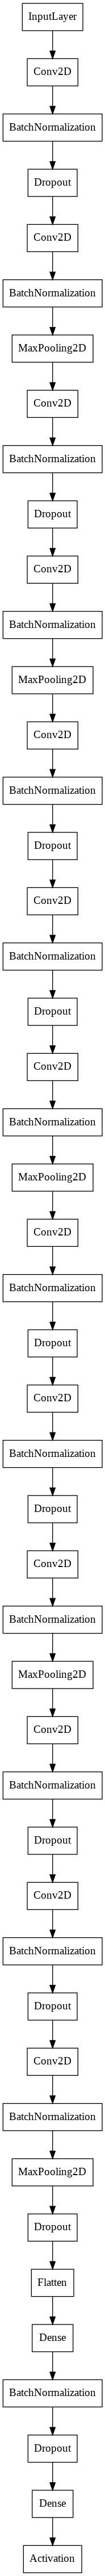

In [36]:
# Code cell 2.5.3
# Display model
from tensorflow.keras import utils
model.summary()
tf.keras.utils.plot_model(model, show_layer_names=False)

In [37]:
# Code cell 2.5.4
# Train
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val_bin))
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(64)

history = model.fit(x_train,  
                    y_train_bin, 
                    steps_per_epoch=x_train.shape[0] // 128,
                    epochs=250, 
                    batch_size=128, 
                    # validation_data=(x_val, y_val_bin))
                    validation_data=val_dataset)

Epoch 1/250
191/191 [==============================] - 13s 67ms/step - loss: 4.2948 - acc: 0.5099 - val_loss: 4.0976 - val_acc: 0.5757
Epoch 2/250
191/191 [==============================] - 12s 64ms/step - loss: 3.8386 - acc: 0.5975 - val_loss: 4.2822 - val_acc: 0.5757
Epoch 3/250
191/191 [==============================] - 12s 64ms/step - loss: 3.4618 - acc: 0.6448 - val_loss: 3.9466 - val_acc: 0.5587
Epoch 4/250
191/191 [==============================] - 12s 64ms/step - loss: 3.2104 - acc: 0.6890 - val_loss: 5.6943 - val_acc: 0.5110
Epoch 5/250
191/191 [==============================] - 12s 63ms/step - loss: 2.9503 - acc: 0.7537 - val_loss: 4.1153 - val_acc: 0.6181
Epoch 6/250
191/191 [==============================] - 12s 63ms/step - loss: 2.7306 - acc: 0.8104 - val_loss: 2.8536 - val_acc: 0.7898
Epoch 7/250
191/191 [==============================] - 12s 63ms/step - loss: 2.5522 - acc: 0.8480 - val_loss: 3.6068 - val_acc: 0.7509
Epoch 8/250
191/191 [==============================] - 

In [39]:
avg_acc = sum(acc)/len(acc)
print(avg_acc)
avg_loss = sum(loss)/len(loss)
print(avg_loss)
avg_vacc = sum(val_acc)/len(val_acc)
print(avg_vacc)
avg_vloss = sum(val_loss)/len(val_loss)
print(avg_vloss)

0.9746917839050293
0.5036567221283913
0.9408203248977661
0.6901687623262406


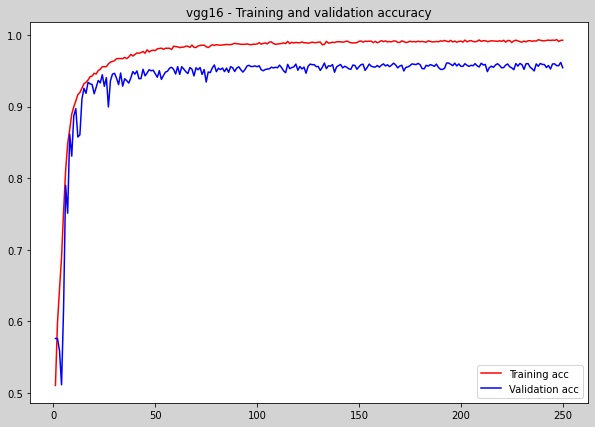

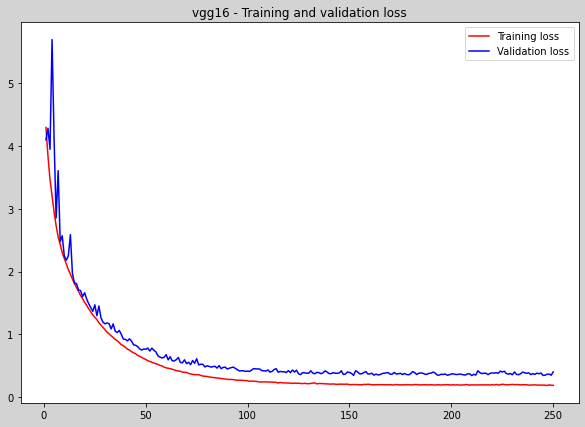

In [38]:
# Code cell 2.5.5
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 7), facecolor='lightgray')
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title(selected_model + ' - Training and validation accuracy')
plt.legend()
# plt.axis([230,250,0.8,1.0])

plt.figure(figsize=(10, 7), facecolor='lightgray')
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title(selected_model + ' - Training and validation loss')
plt.legend()
# plt.axis([230,250,0,1])

plt.show()

In [0]:
# Code cell 2.5.6
# Save the model as a file
models.save_model(model, join('/content/drive/My Drive/Colab Notebooks/fp-speech-recognition/', model_filename))

In [41]:
# Code cell 2.5.7
# TEST: Load model and run it against test set
model = models.load_model(join('/content/drive/My Drive/Colab Notebooks/fp-speech-recognition/', model_filename))
for i in range(80, 100):
    print('Answer:', y_test_bin[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: [0. 0. 0. 0. 1. 0. 0.]  Prediction: [[9.4627017e-09 1.0368180e-07 2.2124046e-10 3.6703653e-08 9.9999094e-01
  4.2275552e-08 8.9548148e-06]]
Answer: [0. 1. 0. 0. 0. 0. 0.]  Prediction: [[2.8230613e-07 9.9992454e-01 6.7190609e-05 3.0789014e-09 1.0550142e-06
  5.6871399e-06 1.2517472e-06]]
Answer: [0. 0. 0. 0. 0. 0. 1.]  Prediction: [[1.5717998e-05 5.2522823e-06 9.8969876e-06 5.7257505e-05 6.6245234e-06
  6.1999899e-06 9.9989903e-01]]
Answer: [0. 0. 0. 0. 0. 0. 1.]  Prediction: [[1.8852194e-05 7.0531482e-06 9.0289032e-06 1.9274044e-05 3.9414613e-06
  7.3994929e-06 9.9993443e-01]]
Answer: [0. 0. 0. 0. 0. 0. 1.]  Prediction: [[5.5950227e-06 1.7443117e-05 1.0154527e-06 1.3357511e-04 9.9844724e-01
  1.3285575e-03 6.6698609e-05]]
Answer: [0. 0. 0. 0. 0. 0. 1.]  Prediction: [[1.4457141e-05 4.7088215e-06 1.0848985e-05 1.8303283e-04 6.9844195e-06
  5.4925058e-06 9.9977440e-01]]
Answer: [0. 0. 0. 0. 0. 0. 1.]  Prediction: [[4.5853353e-06 2.6460405e-06 8.5479678e-06 2.4201997e-06 4.8919314e

In [42]:
# Code cell 2.5.8
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test_bin)

255/255 [==============================] - 2s 10ms/step - loss: 0.4124 - acc: 0.9510


[0.412383109331131, 0.9510489702224731]

# **3 TF Lite Conversion**

In [0]:
# Code cell 3.1.1
from tensorflow import lite
from tensorflow.keras import models

In [44]:
# Code cell 3.1.2
# Parameters
from datetime import datetime
timestamp = datetime.now()
dt_string = timestamp.strftime("%d_%H-%M_")
tflite_filename = dt_string + selected_model + '_wake_word_model_lite.tflite'

print(tflite_filename)

12_14-33_vgg16_wake_word_model_lite.tflite


In [45]:
# Code cell 3.1.3
# Convert model to TF Lite model
model = models.load_model(join('/content/drive/My Drive/Colab Notebooks/fp-speech-recognition/', model_filename))
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(join('/content/drive/My Drive/Colab Notebooks/fp-speech-recognition/', tflite_filename), 'wb').write(tflite_model)

59965804

# **4 Interactive Testing**

In [0]:
# Code cell 4.1.1
from tensorflow.keras import models
model = models.load_model(join('/content/drive/My Drive/Colab Notebooks/fp-speech-recognition/', model_filename))

In [0]:
# Code cell 4.1.2
from IPython.display import Javascript, Audio
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
from pydub import AudioSegment
import time

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  t = 3
  while t > 0:
    print(t, end='...')
    time.sleep(1)
    t-=1
  display(Javascript(RECORD))
  print('RECORD')
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  with open('audio.wav','wb') as f:
    f.write(b)
  return audio, 'audio.wav'

3...2...1...

<IPython.core.display.Javascript object>

RECORD
(32, 48)


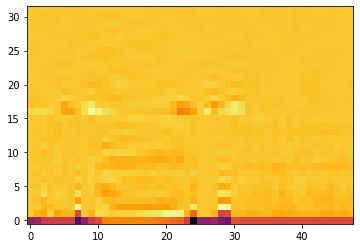

In [0]:
# Code cell 4.1.3
audio_sample, audio_path = record(1)

test_sample = 0
audio_path_TEST = '/content/drive/My Drive/Colab Notebooks/fp-speech-recognition/speech_commands_v0.02/bed/0b77ee66_nohash_2.wav'

if test_sample:
  audio_path = audio_path_TEST

# Generate MFCCs and Deltas
mfccs = calc_mfcc_delta(audio_path)
print(mfccs.shape)

# Plot MFCCs
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')
Audio(filename=audio_path)


In [0]:
# Code cell 4.1.4
in_tensor = np.float32(mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1], 1))
out_tensor = model.predict(in_tensor)
val = np.amax(out_tensor)							
ind = np.where(out_tensor == val)
prediction = ind[1].astype(int)

print('Prediction:', prediction, 'Accuracy:', val)
print(out_tensor)

Prediction: [6] Accuracy: 1.0
[[2.4538366e-13 3.7613389e-24 2.2901238e-22 7.1070536e-27 2.6101992e-12
  4.4960856e-17 1.0000000e+00]]
